# Classificação de florestas

In [1]:
!pip install -q kaggle
#!mkdir ~/.kaggle
!cp dados/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
## Analise dos dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint, uniform
from sklearn.neural_network import MLPClassifier

train_data = pd.read_csv('dados/train.csv')

**Analisar as primeiras linhas do conjunto de treino** com esta análise conseguimos perceber que todas as colunas indicam atributos numéricos e categóricos.  
**Dados numéricos e categóricos**, maioria dos atributos é numérica. No entanto, as colunas **solo** e **area** são categóricas, pois podem representar classes específicas.
A coluna floresta é o alvo (target), pois apresenta valores que indicam diferentes tipos de florestas (3, 6, etc.). Isso sugere que este é um problema de classificação multiclasse.

In [3]:
train_data.head()

,id,elevacao,aspeto,inclinacao,dh_agua,dv_agua,dh_estrada,sombra_9,sombra_12,sombra_15,dh_Incendio,area,solo,floresta
0,1,2596,51,3,258,0,510,221,232,148,6279,4,5,6
1,2,2785,155,18,242,118,3090,238,238,122,6211,4,5,3
2,3,2579,132,6,300,-15,67,230,237,140,6031,4,5,3
3,4,2606,45,7,270,5,633,222,225,138,6256,4,5,6
4,5,2605,49,4,234,7,573,222,230,144,6228,4,5,6


Aqui podemos ver que todos os atributos são numéricos que nao existem valores nulos

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10620 entries, 0 to 10619
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   id           10620 non-null  int64
 1   elevacao     10620 non-null  int64
 2   aspeto       10620 non-null  int64
 3   inclinacao   10620 non-null  int64
 4   dh_agua      10620 non-null  int64
 5   dv_agua      10620 non-null  int64
 6   dh_estrada   10620 non-null  int64
 7   sombra_9     10620 non-null  int64
 8   sombra_12    10620 non-null  int64
 9   sombra_15    10620 non-null  int64
 10  dh_Incendio  10620 non-null  int64
 11  area         10620 non-null  int64
 12  solo         10620 non-null  int64
 13  floresta     10620 non-null  int64
dtypes: int64(14)
memory usage: 1.1 MB


Usamos o “sns.heatmap()” para se visualizar a correlação entre os atributos numéricos e verificámos
que onde existe as maiores relações é nos atributos "sombra_12", "sombra_15" e onde existe as maiores diferenças é nos atributos "sombra_9", "sombra_15" 

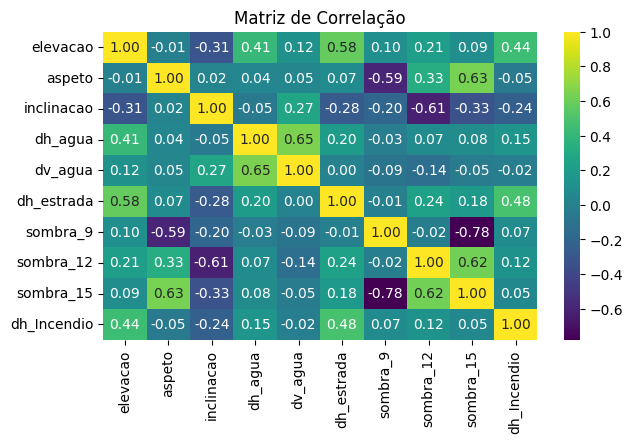

In [5]:
# Selecionando apenas as colunas numéricas
numerical_cols = ['elevacao', 'aspeto', 'inclinacao', 'dh_agua', 'dv_agua', 
                  'dh_estrada', 'sombra_9', 'sombra_12', 'sombra_15', 'dh_Incendio']
# Visualizar a matriz de correlação
plt.figure(figsize=(7, 4))
sns.heatmap(train_data[numerical_cols].corr(), annot=True, cmap="viridis", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

In [6]:
train_data

,id,elevacao,aspeto,inclinacao,dh_agua,dv_agua,dh_estrada,sombra_9,sombra_12,sombra_15,dh_Incendio,area,solo,floresta
0,1,2596,51,3,258,0,510,221,232,148,6279,4,5,6
1,2,2785,155,18,242,118,3090,238,238,122,6211,4,5,3
2,3,2579,132,6,300,-15,67,230,237,140,6031,4,5,3
3,4,2606,45,7,270,5,633,222,225,138,6256,4,5,6
4,5,2605,49,4,234,7,573,222,230,144,6228,4,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10615,10616,2617,45,9,240,56,666,223,221,133,6244,4,5,6
10616,10617,2503,157,4,67,4,674,224,240,151,5600,4,18,6
10617,10618,2610,259,1,120,-1,607,216,239,161,6096,4,5,6
10618,10619,2570,346,2,0,0,331,215,235,158,5745,4,5,3


Quanto aos atributos "area" e "solo", usamos um Barplot para mostrar a distribuição do atributo alvo
“floresta” para diferentes categorias do atributo “area” e "solo". Podemos verificar que os atributos influ-
enciam o número de floresta e que a categoria 1 do atributo area e 2, 9 e 15 do atributo solo são as que influenciam mais no tipo de floresta.

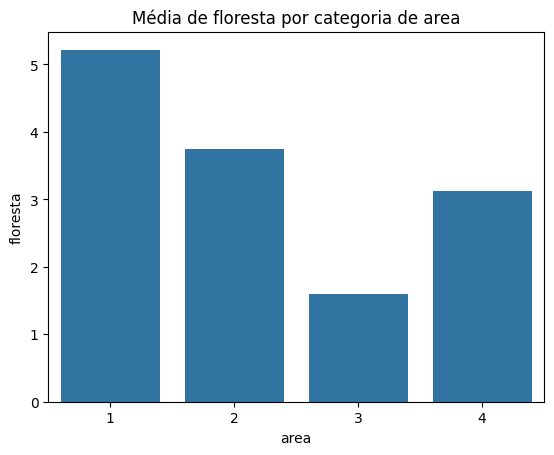

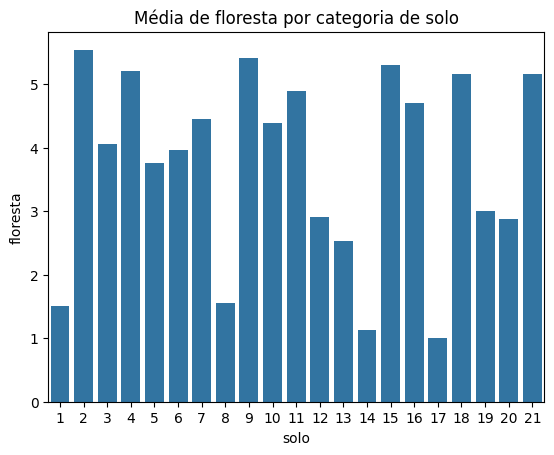

In [7]:
mean_floresta_by_area = train_data.groupby('area')['floresta'].mean().reset_index()
sns.barplot(x='area', y='floresta', data=mean_floresta_by_area)
plt.title('Média de floresta por categoria de area')
plt.show()

mean_floresta_by_solo = train_data.groupby('solo')['floresta'].mean().reset_index()
sns.barplot(x='solo', y='floresta', data=mean_floresta_by_solo)
plt.title('Média de floresta por categoria de solo')
plt.show()


# Normalização/Padrão dos Dados Numéricos
Para normalizar ou padronizar os dados numéricos, vamos usar o StandardScaler. Isso é especialmente importante quando temos diferentes escalas de valores (como elevacao e dh_agua).
## Codificação de Variáveis Categóricas
Codificamos as variáveis categóricas, como solo e area para serem variaveis de tipo "category".

In [8]:
def preprocessing_td(df, target=None, scaler=None):
    df_processed = df.copy()
    if target is not None:
        target_data = df_processed.pop(target)
# Tratar colunas categóricas como 'solo' e 'area' (já codificadas como números inteiros)
    categorical_columns = ['solo', 'area']
    for col in categorical_columns:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].astype('category')
# Identificar colunas numéricas para normalização
    num_cols = df_processed.select_dtypes(include=['int64']).columns
    # Excluir colunas categóricas dos números
    num_cols = [col for col in num_cols if col not in categorical_columns]
    
    if scaler is None:
        scaler = MinMaxScaler()
        df_processed[num_cols] = scaler.fit_transform(df_processed[num_cols])
    else:
        df_processed[num_cols] = scaler.transform(df_processed[num_cols])
    
    # Adicionar de volta a variável-alvo, se separada
    if target is not None:
        df_processed[target] = target_data
    
    return df_processed, scaler

In [9]:
train_data, train_scaler = preprocessing_td(train_data, target=train_data.columns[-1])

In [10]:
train_data

,id,elevacao,aspeto,inclinacao,dh_agua,dv_agua,dh_estrada,sombra_9,sombra_12,sombra_15,dh_Incendio,area,solo,floresta
0,0.000000,0.363959,0.141667,0.057692,0.192107,0.194767,0.074020,0.870079,0.858065,0.599190,0.916241,4,5,6
1,0.000094,0.459898,0.430556,0.346154,0.180194,0.366279,0.448476,0.937008,0.896774,0.493927,0.906318,4,5,3
2,0.000188,0.355330,0.366667,0.115385,0.223380,0.172965,0.009724,0.905512,0.890323,0.566802,0.880053,4,5,3
3,0.000283,0.369036,0.125000,0.134615,0.201042,0.202035,0.091872,0.874016,0.812903,0.558704,0.912885,4,5,6
4,0.000377,0.368528,0.136111,0.076923,0.174237,0.204942,0.083164,0.874016,0.845161,0.582996,0.908799,4,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10615,0.999623,0.374619,0.125000,0.173077,0.178704,0.276163,0.096662,0.877953,0.787097,0.538462,0.911134,4,5,6
10616,0.999717,0.316751,0.436111,0.076923,0.049888,0.200581,0.097823,0.881890,0.909677,0.611336,0.817160,4,18,6
10617,0.999812,0.371066,0.719444,0.019231,0.089352,0.193314,0.088099,0.850394,0.903226,0.651822,0.889537,4,5,6
10618,0.999906,0.350761,0.961111,0.038462,0.000000,0.194767,0.048041,0.846457,0.877419,0.639676,0.838319,4,5,3


## Divisão dos Dados em Conjunto de Treinamento e Teste

In [11]:
# Select features by index slicing
selected_features = train_data.iloc[:, 1:-1]
# Select the target variable
target = train_data['floresta']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(selected_features, target, test_size=0.2, random_state=42)

# Escolha do modelo 

## Rede Neuronal

In [12]:
# Configurar o modelo de rede neural
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(100,),  # Duas camadas ocultas com 100 e 50 neurônios
    activation='relu',            # Função de ativação (ReLU)
    solver='adam',                # Otimizador (Adam)
    learning_rate='adaptive',     # Taxa de aprendizado adaptativa
    max_iter=1000,                 # Máximo de iterações
    random_state=42               # Random state para reprodutibilidade
)

# Treinar o modelo
mlp_classifier.fit(X_train, y_train)

# Fazer previsões
y_pred_mlp = mlp_classifier.predict(X_test)

# Avaliar o modelo
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

# Exibir métricas de desempenho
print(f"Acurácia: {accuracy_mlp}")
print(f"RMSE: {rmse_mlp}")
print(f"R²: {r2_mlp}")

Acurácia: 0.737758945386064
RMSE: 1.1838922050996317
R²: 0.6510050163474078


In [13]:
# Definir os hiperparâmetros e os intervalos de busca
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),  # Amostras aleatórias entre 0.0001 e 0.01
    'learning_rate': ['constant', 'adaptive'],
}

# Configurar o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=MLPClassifier(max_iter=2000, random_state=42, early_stopping=True),
    param_distributions=param_dist,
    n_iter=50,  # Número de combinações aleatórias a serem testadas
    scoring='accuracy',
    cv=3,  # Validação cruzada com 3 divisões
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Ajustar o modelo aos dados
random_search.fit(X_train, y_train)

# Exibir os melhores parâmetros e o desempenho correspondente
print(f"Melhores parâmetros: {random_search.best_params_}")
print(f"Melhor acurácia: {random_search.best_score_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Melhores parâmetros: {'activation': 'relu', 'alpha': np.float64(0.006610770255019445), 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Melhor acurácia: 0.6903248587570622


Após execução do Random Search a melhor escolha dos parametros é a seguinte: Melhores parâmetros: {'activation': 'relu', 'alpha': np.float64(0.006610770255019445), 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}

In [14]:
# Inicializar o modelo com os melhores parâmetros
mlp_best = MLPClassifier(
    activation='relu',
    alpha=np.float64(0.006610770255019445),
    hidden_layer_sizes=(150, 100, 50),
    learning_rate='constant',
    solver='adam',
    max_iter=2000,  # Ajustar max_iter para garantir convergência
    random_state=42
)

# Treinar o modelo com os melhores parâmetros
mlp_best.fit(X_train, y_train)

# Fazer previsões
y_pred_best = mlp_best.predict(X_test)

# Avaliar o modelo
accuracy_best = accuracy_score(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

# Exibir métricas de desempenho
print(f"Acurácia (melhor modelo): {accuracy_best}")
print(f"RMSE (melhor modelo): {rmse_best}")
print(f"R² (melhor modelo): {r2_best}")


Acurácia (melhor modelo): 0.7848399246704332
RMSE (melhor modelo): 1.0340256474324139
R² (melhor modelo): 0.7337696983960239


## Submissão do modelo

In [15]:
# load test data
test_data = pd.read_csv("dados/test.csv")
test_data, _ = preprocessing_td(test_data, scaler=train_scaler)
test_data = test_data.iloc[:, 1:] # Select columns from index 1 to 2 (exclusive)

predicted_test = mlp_best.predict(test_data)
submission = pd.read_csv("dados/sample_submission.csv")
submission['floresta'] = predicted_test 
submission.to_csv("dados/submission.csv", index=False)
submission.head()
#!kaggle competitions submit -c classificacao-florestas -f dados/submission.csv -m "Modelo com Rede Neuronal"

,id,floresta
0,10621,2
1,10622,6
2,10623,6
3,10624,6
4,10625,6


**Score no Kaggle** com este modelo, o score no Kaggle foi de RMSE 0.77535

## Random Forest Classifier

In [16]:
# Treinando o modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)

# Avaliação
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
# Calcular o RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

Acurácia: 0.85969868173258
              precision    recall  f1-score   support

           1       0.93      0.97      0.95       316
           2       0.80      0.78      0.79       312
           3       0.80      0.71      0.75       299
           4       0.82      0.85      0.83       292
           5       0.93      0.93      0.93       301
           6       0.89      0.92      0.90       319
           7       0.84      0.86      0.85       285

    accuracy                           0.86      2124
   macro avg       0.86      0.86      0.86      2124
weighted avg       0.86      0.86      0.86      2124

RMSE: 0.8075094817328848


## Submissão do modelo

In [17]:
# load test data
test_data = pd.read_csv("dados/test.csv")
test_data, _ = preprocessing_td(test_data, scaler=train_scaler)
test_data = test_data.iloc[:, 1:] # Select columns from index 1 to 2 (exclusive)

predicted_test = model.predict(test_data)
submission = pd.read_csv("dados/sample_submission.csv")
submission['floresta'] = predicted_test 
submission.to_csv("dados/submission.csv", index=False)
#submission.head()
#!kaggle competitions submit -c classificacao-florestas -f dados/submission.csv -m "Modelo com Randon Forest"

**Score no Kaggle** com este modelo, o score no Kaggle foi de RMSE 0.84330

## Ajuste do Modelo

In [ ]:
# Espaço de hiperparâmetros
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': [None] + list(range(10, 50)),
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 5),
}

# Modelo base
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',  # Métrica de avaliação
    random_state=42
)

# Ajustar o modelo
random_search.fit(X_train, y_train)

# Melhor modelo
print("Melhores parâmetros:", random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Após execução do Randomized Search a melhor escolha dos parametros é a seguinte: Melhores parâmetros: {'max_depth': 38, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 416}

In [19]:
# Melhor configuração de hiperparâmetros
best_params = {'max_depth': 38, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 416}

# Criar o modelo com os melhores parâmetros
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Treinar o modelo nos dados de treino
best_rf.fit(X_train, y_train)

# Fazer previsões
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy}")
print(f"RMSE: {rmse}")

Acurácia: 0.8615819209039548
RMSE: 0.8075094817328848


In [21]:
# load test data
test_data = pd.read_csv("dados/test.csv")
test_data, _ = preprocessing_td(test_data, scaler=train_scaler)
test_data = test_data.iloc[:, 1:] # Select columns from index 1 to 2 (exclusive)

predicted_test = best_rf.predict(test_data)
submission = pd.read_csv("dados/sample_submission.csv")
submission['floresta'] = predicted_test 
submission.to_csv("dados/submission.csv", index=False)
#submission.head()
#!kaggle competitions submit -c classificacao-florestas -f dados/submission.csv -m "Modelo com Random Forest Regressor (RandomizedSearchCV)"

**Score no Kaggle** com este modelo, o score no Kaggle foi de RMSE 0.84908

## Regressão Linear

*Treinamento de um Modelo Linear*

O modelo mais comum para classificação multiclasse é a Regressão Logística, que pode ser configurada para lidar com múltiplas classes automaticamente.

In [22]:
# Criar e treinar o modelo
model = LogisticRegression(solver='sag', random_state=42)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

/home/luis/meu_ambiente/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
# Acurácia
print("Acurácia:", accuracy_score(y_test, y_pred))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
# Relatório detalhado
print("\nRelatório de Classificação:")
#print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Acurácia: 0.6530131826741996
RMSE: 1.3407280817068064

Relatório de Classificação:


## Submissão do modelo

In [24]:
# load test data
test_data = pd.read_csv("dados/test.csv")
test_data, _ = preprocessing_td(test_data, scaler=train_scaler)
test_data = test_data.iloc[:, 1:] # Select columns from index 1 to 2 (exclusive)

predicted_test = model.predict(test_data)
submission = pd.read_csv("dados/sample_submission.csv")
submission['floresta'] = predicted_test 
submission.to_csv("dados/submission.csv", index=False)
submission.head()
#!kaggle competitions submit -c classificacao-florestas -f dados/submission.csv -m "Modelo com Regressão Logística"

,id,floresta
0,10621,3
1,10622,3
2,10623,3
3,10624,3
4,10625,3


**Score no Kaggle** com este modelo, o score no Kaggle foi de RMSE 0.64479

## Gradient Boosting Classifier

In [25]:
# Criar e configurar o modelo de classificação
gb_classifier = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Treinar o modelo
gb_classifier.fit(X_train, y_train)

# Fazer previsões
y_pred = gb_classifier.predict(X_test)

# Acurácia
accuracy = accuracy_score(y_test, y_pred)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Acurácia: {accuracy}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

Acurácia: 0.7923728813559322
RMSE: 1.022809542240725
R²: 0.739513989359738


In [ ]:
# Espaço de hiperparâmetros
param_dist = {
'n_estimators': [100, 200, 300], # Número de árvores
'learning_rate': [0.01, 0.1, 0.2], # Taxa de aprendizagem
'max_depth': [3, 4, 5], # Profundidade máxima de cada árvore
'min_samples_split': [2, 4], # Número mínimo de amostras para dividir um nó
'min_samples_leaf': [1, 2] # Número mínimo de amostras em uma folha
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Executar busca
random_search.fit(X_train, y_train)

# Melhor modelo
best_gb = random_search.best_estimator_

# Avaliar no conjunto de teste
y_pred = best_gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Melhores parâmetros: {random_search.best_params_}")
print(f"Acurácia após otimização: {accuracy}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Após execução do Randomized Search a melhor escolha dos parametros é a seguinte: Melhores parâmetros: {'n_estimators': 141, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_depth': 9, 'learning_rate': 0.13999278615555305}

In [ ]:
# Configurar o modelo com os melhores parâmetros
gb_classifier_optimized = GradientBoostingClassifier(
    learning_rate=0.13999278615555305,  # Taxa de aprendizado ajustada
    max_depth=9,                        # Profundidade máxima ajustada
    min_samples_leaf=3,                 # Mínimo de amostras em um nó folha
    min_samples_split=16,               # Mínimo de amostras para dividir um nó
    n_estimators=141,                   # Número de árvores ajustado
    random_state=42                     # Random state para reprodutibilidade
)

# Treinar o modelo otimizado
gb_classifier_optimized.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_optimized = gb_classifier_optimized.predict(X_test)

# Avaliar o modelo otimizado
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
rmse_optimized = np.sqrt(mse_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

# Exibir métricas de desempenho
print(f"Acurácia: {accuracy_optimized}")
print(f"RMSE: {rmse_optimized}")
print(f"R²: {r2_optimized}")


In [ ]:
# load test data
test_data = pd.read_csv("dados/test.csv")
test_data, _ = preprocessing_td(test_data, scaler=train_scaler)
test_data = test_data.iloc[:, 1:] # Select columns from index 1 to 2 (exclusive)

predicted_test = gb_classifier_optimized.predict(test_data)
submission = pd.read_csv("dados/sample_submission.csv")
submission['floresta'] = predicted_test 
submission.to_csv("dados/submission.csv", index=False)
submission.head()
#!kaggle competitions submit -c classificacao-florestas -f dados/submission.csv -m "Submissão do modelo GBClassifier"

**Score no Kaggle** com este modelo, o score no Kaggle foi de RMSE 0.84874

## Melhor modelo

O modelo que nos mostrou melhores resultados foi o Random Florest Classifier. Inicialmente, o modelo foi treinado com parâmetros padrão e resultou num Acurácia de 0.85969868173258 e um RMSE de 0.8075094817328848.
Achámos que o modelo poderia ter potencial neste problema e decidimos melhorar o desempenho do modelo. Foi realizado um processo de otimização de parâmetros utilizando RandomizedSearchCV. Os parâmetros a ajustar foram o número de árvores, a taxa de aprendizagem, a profundidade máxima de cada árvore, o número mínimo de amostras para dividir um nó, e o número mínimo de amostras em uma folha.
A melhor configuração encontrada foi: - 'max_depth': 38, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 416
Após a otimização, o modelo ajustado foi treinado e avaliado, obtendo o mesmo RMSE de
0.85969868173258 e o aumento da Acurácia 0.8615819209039548, indicando uma melhoria significativa em relação à configuração padrão.
Com base nos resultados obtidos, o modelo RandomForestClassifier otimizado provou ser a escolha mais eficaz para o problema em questão, superando outras abordagens testadas e demonstrando um equilíbrio ideal entre complexidade e desempenho. No Kaggle obteve um **score** de 0.84908.